In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [2]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

def sammon_error(X, X_low):
    """
    Calculate Sammon error (stress) between original data X and low-dimensional data X_low.
    
    Parameters:
    - X: Original data (n_samples, n_features)
    - X_low: Data with selected features or reduced dimensions (n_samples, k_features)
    
    Returns:
    - sammon_error: Sammon error (float)
    """
    # Compute pairwise distances in the original data
    D_orig = pdist(X, metric='euclidean')
    D_orig = squareform(D_orig)  # Convert to a square matrix
    
    # Compute pairwise distances in the low-dimensional data (selected features)
    D_low = pdist(X_low, metric='euclidean')
    D_low = squareform(D_low)
    
    # Avoid division by zero by replacing zeros with a small number
    D_orig[D_orig == 0] = np.finfo(float).eps
    
    # Calculate the Sammon error (Sammon stress)
    delta = D_orig - D_low
    sammon_error = np.sum((delta**2) / D_orig)
    
    # Normalize the error by the sum of original distances
    sammon_error /= np.sum(D_orig)
    
    return sammon_error


In [3]:
def ss_sfs(X, max_features=None):
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    n_samples, n_features = X_scaled.shape
    selected_features = []
    remaining_features = list(range(n_features))
    best_silhouette = -1
    
    while remaining_features:
        best_feature = None
        best_silhouette_candidate = -1
        
        for feature in remaining_features:
            # Form dataset with currently selected + one candidate feature
            candidate_features = selected_features + [feature]
            X_candidate = X_scaled[:, candidate_features]
            
            # Perform clustering (e.g., KMeans) and calculate silhouette score
            kmeans = KMeans(n_clusters=2, random_state=42)  # You can change n_clusters based on the problem
            labels = kmeans.fit_predict(X_candidate)
            silhouette_avg = silhouette_score(X_candidate, labels)
            
            if silhouette_avg > best_silhouette_candidate:
                best_silhouette_candidate = silhouette_avg
                best_feature = feature
        
        if best_silhouette_candidate > best_silhouette:
            best_silhouette = best_silhouette_candidate
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
        else:
            break  # Stop if silhouette score does not improve
        
        # Stop if max_features is reached
        if max_features and len(selected_features) >= max_features:
            break
    
    return selected_features

In [4]:
def ss_sfs_sammon(X, max_features=None):
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    n_samples, n_features = X_scaled.shape
    selected_features = []
    remaining_features = list(range(n_features))
    best_sammon_error = np.inf  # Start with a high Sammon error
    
    while remaining_features:
        best_feature = None
        best_sammon_candidate = np.inf
        
        for feature in remaining_features:
            # Form dataset with currently selected + one candidate feature
            candidate_features = selected_features + [feature]
            X_candidate = X_scaled[:, candidate_features]
            
            # Calculate Sammon error
            error = sammon_error(X_scaled, X_candidate)
            
            if error < best_sammon_candidate:
                best_sammon_candidate = error
                best_feature = feature
        
        if best_sammon_candidate < best_sammon_error:
            best_sammon_error = best_sammon_candidate
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
        else:
            break  # Stop if Sammon error does not improve
        
        # Stop if max_features is reached
        if max_features and len(selected_features) >= max_features:
            break
    
    return selected_features

In [5]:
data_train = pd.read_csv("../data/data_train.csv", sep=',')
data_test = pd.read_csv("../data/data_test.csv", sep=',')
# Concatenate the data along rows (axis=0)
data = pd.concat([data_train, data_test], axis=0)
# data.drop(columns=["Unnamed:"], inplace=True)
# Display the first few rows of the combined DataFrame
data.head()

,repository,LCOM5,WMC,CBO,NOI_c,RFC,CLOC_c,DIT,NOA,NOC,...,TNOS_m,HCPL,HDIF,HEFF,HNDB,HPL,HPV,HTRP,HVOL,MI
0,recommenders-team_recommenders,3.484536,13.948454,0.268041,0.175258,5.865979,47.845361,0.030928,0.030928,0.030928,...,10.424908,17.626091,0.946289,123.713377,0.011553,8.822311,5.909960,6.872965,34.659469,52.708286
1,ansible_ansible,2.460000,11.521935,0.383871,0.249032,3.944516,9.249677,0.267097,0.274839,0.223871,...,8.096763,16.960101,0.821704,140.214293,0.010462,7.453463,5.358586,7.789683,31.384585,43.619663
2,python_mypy,4.745626,20.709287,0.522207,0.554509,8.247645,17.150740,0.803499,0.816958,0.366083,...,5.554887,15.700527,0.851261,123.168731,0.009638,7.055235,5.086295,6.842707,28.915393,25.116836
3,hpcaitech_ColossalAI,3.167149,10.542692,0.329233,0.335745,4.484805,15.290883,0.156295,0.156295,0.138205,...,7.389521,19.964883,1.040007,203.418684,0.014098,9.626516,5.939346,11.301038,42.294285,53.518406
4,httpie_cli,2.305389,5.107784,0.365269,0.221557,3.113772,4.874251,0.257485,0.263473,0.239521,...,4.327044,10.140832,0.789708,36.672611,0.005911,5.623834,4.638342,2.037367,17.734353,49.713385


In [6]:
X = data.drop(columns=["repository"], inplace=False)
X = X.to_numpy()
X, X.shape

(array([[ 3.48453608, 13.94845361,  0.26804124, ...,  6.87296538,
         34.65946915, 52.70828605],
        [ 2.46      , 11.52193548,  0.38387097, ...,  7.78968294,
         31.38458498, 43.61966283],
        [ 4.74562584, 20.70928668,  0.52220727, ...,  6.84270728,
         28.91539346, 25.11683622],
        ...,
        [ 2.3255814 ,  8.27906977,  0.18604651, ...,  3.40929386,
         17.50147704, 39.29376925],
        [ 2.42245073,  4.8243359 ,  0.62810626, ...,  0.536904  ,
          5.48251962, 45.69017571],
        [ 0.94726166,  2.78498986,  0.20689655, ..., 12.64236351,
         17.16930872, 50.99262724]]),
 (106, 42))

In [7]:
 # Generate some example data (replace with your dataset)
# from sklearn.datasets import make_blobs
# X, _ = make_blobs(n_samples=100, n_features=5, centers=3, random_state=42)

selected_features = ss_sfs_sammon(X, max_features=15)
print("Selected features:", selected_features)

Selected features: [34, 19, 8, 22, 31, 41, 35, 25, 2, 1, 0, 30, 7, 38, 3]


In [8]:
selected_data = data.drop(columns=["repository"]).iloc[:, selected_features]

In [9]:
selected_data

,HDIF,TNLM,NOC,NOI_m,TLOC_m,MI,HEFF,TCLOC,CBO,WMC,LCOM5,TLLOC_m,NOA,HPV,NOI_c
0,0.946289,5.690722,0.030928,0.437729,29.465201,52.708286,123.713377,7.617216,0.268041,13.948454,3.484536,19.769231,0.030928,5.909960,0.175258
1,0.821704,3.702581,0.223871,0.455017,15.333930,43.619663,140.214293,2.103023,0.383871,11.521935,2.460000,11.608120,0.274839,5.358586,0.249032
2,0.851261,7.714670,0.366083,0.635977,11.310021,25.116836,123.168731,1.739200,0.522207,20.709287,4.745626,9.312854,0.816958,5.086295,0.554509
3,1.040007,4.164978,0.138205,0.335321,16.085456,53.518406,203.418684,2.607046,0.329233,10.542692,3.167149,12.323397,0.156295,5.939346,0.335745
4,0.789708,2.916168,0.239521,0.316562,10.245283,49.713385,36.672611,1.134172,0.365269,5.107784,2.305389,8.633124,0.263473,4.638342,0.221557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,0.977564,5.808126,0.345372,0.474416,15.933924,23.350238,186.802713,6.085415,0.680587,13.980813,3.996614,9.288678,0.572235,5.597757,0.638826
18,0.592973,9.532033,0.203343,0.200059,27.362349,41.787945,93.679847,16.027442,0.245125,14.493036,7.777159,11.295958,0.389972,3.098542,0.164345
19,0.667386,3.034884,0.046512,0.352697,16.070539,39.293769,61.367290,4.813278,0.186047,8.279070,2.325581,10.066390,0.058140,4.134328,0.279070
20,0.275640,3.465296,0.284490,0.373565,10.441656,45.690176,9.664272,0.629105,0.628106,4.824336,2.422451,9.314286,0.394173,1.558270,0.195373


In [10]:
# Select two features from the data (e.g., columns 0 and 1)
X_low = selected_data.to_numpy()

# Calculate Sammon error between original and selected features
error = sammon_error(X, X_low)
print(f"Sammon error: {error}")


Sammon error: 0.1274296936676241


In [15]:
N = X.shape[1]
errors = []
num_ftrs = []
for n in range(1, N):
    print("max_features ", n)
    selected_features = ss_sfs_sammon(X, max_features=n)
    print('\tselected features', selected_features)
    selected_data = data.drop(columns=["repository"]).iloc[:, selected_features]
    X_low = selected_data.to_numpy()
    error = sammon_error(X, X_low)
    print(f"\tSammon error: {error}")
    
    errors.append(error)
    num_ftrs.append(n)


max_features  1
	selected features [34]
	Sammon error: 0.9960805721480023
max_features  2
	selected features [34, 19]
	Sammon error: 0.9791878369323492
max_features  3
	selected features [34, 19, 8]
	Sammon error: 0.9790664835760133
max_features  4
	selected features [34, 19, 8, 22]
	Sammon error: 0.9789365398628285
max_features  5
	selected features [34, 19, 8, 22, 31]
	Sammon error: 0.9351128418092713
max_features  6
	selected features [34, 19, 8, 22, 31, 41]
	Sammon error: 0.8445700784580384
max_features  7
	selected features [34, 19, 8, 22, 31, 41, 35]
	Sammon error: 0.13155363585914195
max_features  8
	selected features [34, 19, 8, 22, 31, 41, 35, 25]
	Sammon error: 0.13092702359135516
max_features  9
	selected features [34, 19, 8, 22, 31, 41, 35, 25, 2]
	Sammon error: 0.13092430820190995
max_features  10
	selected features [34, 19, 8, 22, 31, 41, 35, 25, 2, 1]
	Sammon error: 0.12884741779232603
max_features  11
	selected features [34, 19, 8, 22, 31, 41, 35, 25, 2, 1, 0]
	Sammon e

In [12]:
selected_data = data.drop(columns=["repository"]).iloc[:, [34, 19, 8, 22, 31, 41, 35]]
selected_data

,HDIF,TNLM,NOC,NOI_m,TLOC_m,MI,HEFF
0,0.946289,5.690722,0.030928,0.437729,29.465201,52.708286,123.713377
1,0.821704,3.702581,0.223871,0.455017,15.333930,43.619663,140.214293
2,0.851261,7.714670,0.366083,0.635977,11.310021,25.116836,123.168731
3,1.040007,4.164978,0.138205,0.335321,16.085456,53.518406,203.418684
4,0.789708,2.916168,0.239521,0.316562,10.245283,49.713385,36.672611
...,...,...,...,...,...,...,...
17,0.977564,5.808126,0.345372,0.474416,15.933924,23.350238,186.802713
18,0.592973,9.532033,0.203343,0.200059,27.362349,41.787945,93.679847
19,0.667386,3.034884,0.046512,0.352697,16.070539,39.293769,61.367290
20,0.275640,3.465296,0.284490,0.373565,10.441656,45.690176,9.664272


In [13]:
import matplotlib.pyplot as plt

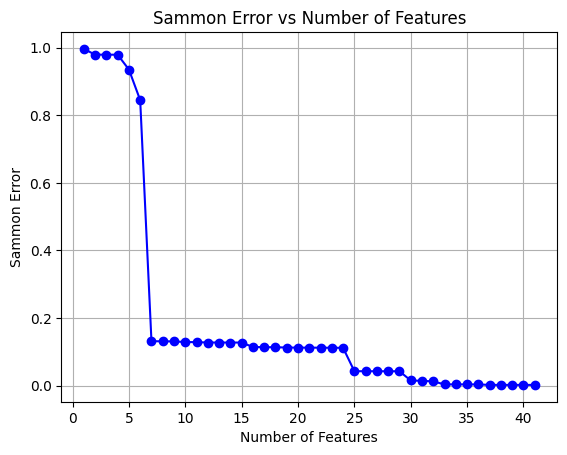

In [16]:
# Plot
plt.plot(num_ftrs, errors, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Features')
plt.ylabel('Sammon Error')
plt.title('Sammon Error vs Number of Features')
plt.grid(True)
plt.show()

data collection

DA

SE + optim tech 

Res aggr and compar